Import all the relevant stuff

In [1]:
# eeg analysis libraries
import mne

# import plotting libraries
from matplotlib import pyplot as plt
# python version of ggplot:
from plotnine import *

# numerical libraries
import numpy as np
import pandas as pd

# import tqdm for a progress bar:
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# import file path operators
from pathlib import Path
import os

# avoid MNE being too verbose
mne.set_log_level('INFO')

/Library/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


List all files

In [2]:
from data import raws, events, n

for raw in raws():
    print(raw.info['subject_info'])

{'pid': '0001', 'group': 'CTR'}
{'pid': '0025', 'group': 'CTR'}


Run preprocessing

Widget Javascript not detected.  It may not be installed or enabled properly.


Creating RawArray with float64 data, n_channels=2, n_times=252928
    Range : 0 ... 252927 =      0.000 ...   246.999 secs
Ready.
SSP projectors applied...
Reading data/interim/0001-ica.fif.gz ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
Now restoring ICA solution ...
Ready.


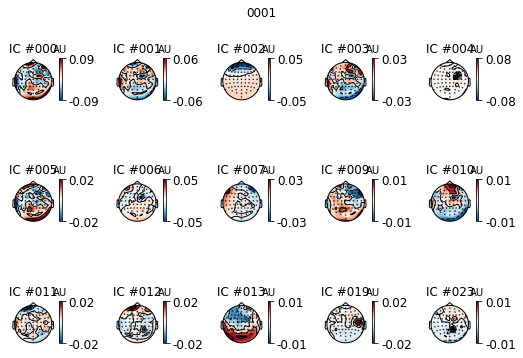

Transforming to ICA space (24 components)
Zeroing out 15 ICA components
28 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 28 events and 1025 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=2, n_times=259072
    Range : 0 ... 259071 =      0.000 ...   252.999 secs
Ready.
SSP projectors applied...
Fitting ICA to data using 64 channels. 
Please be patient, this may take some time
Selection by explained variance: 10 components
<ICA  |  raw data decomposition, fit (fastica): 64768 samples, 10 components, channels used: "eeg">
    Now searching for artifacts...
    found 7 artifacts by EOG 00
    found 5 artifacts by EOG 01
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    0, 1, 2, 3, 4, 6, 9, 0, 1, 2, 3, 4, 9, 9, 6
    Removing duplicate indices...
Ready.
Writing ica solution to data/interim/0025-ica.

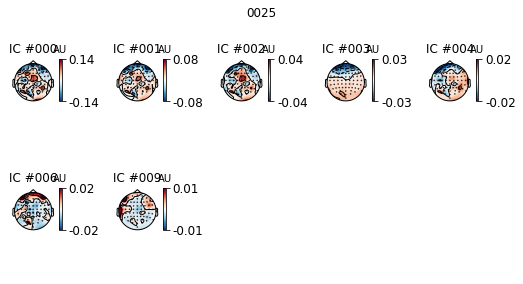

Transforming to ICA space (10 components)
Zeroing out 7 ICA components
28 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 28 events and 1025 original time points ...
0 bad epochs dropped



In [5]:
# length of segments over which analysis is run:
segment_length = 4

for raw, event in tqdm(zip(raws(), events()), total=n):
    
    original_frequency = raw.info['sfreq']

    # load the raw data
    raw = raw.load_data()
    subid = (raw.info['subject_info']['pid'])
    
    # create a new virtual channel for the VEOG and HEOG
    veog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG3', 'EXG4']), :]
    veog = np.diff(veog, axis=0)
    heog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG1', 'EXG2']), :]
    heog = np.diff(heog, axis=0)
    
    new_info = mne.create_info(['VEOG', 'HEOG'], 1024, ch_types='eog')
    raw.info['lowpass'] = new_info['lowpass'] = 1024
    
    # add these two new channels to the data
    raw = raw.add_channels(
        [mne.io.RawArray(np.concatenate([veog, heog], axis=0), new_info)]
    )
    
    # drop extra channels (not used)
    raw = raw.drop_channels(['EXG7', 'EXG8'])
    # resample the data (w/ parallel processing)
    raw = raw.resample(256, n_jobs = 6)


    # set the average of the mastoids as reference
    raw = raw.set_eeg_reference()
    raw = raw.apply_proj()
        
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, eeg=False, eog=True), n_jobs=6)
    # filter the EEG data (bandstop for mains and all harmonics)
    raw = raw.notch_filter(np.arange(50, raw.info['lowpass'], 50), n_jobs=6)
    # high-pass filter the data
    raw = raw.filter(0.5, 45, n_jobs=6)
    
    
    # Run ICA
    # -------
    ica_file = f'data/interim/{subid}-ica.fif.gz'
    # the following is only run if no ICA is present so far
    if not os.path.isfile(ica_file):
        # run an ICA to remove components correlated with both horizontal and vertical EOG traces
        seed = np.random.RandomState(2017)
        ica = mne.preprocessing.run_ica(raw, n_components=0.99, max_pca_components=64,
                                        random_state=seed, eog_ch=['HEOG', 'VEOG'],
                                        picks=mne.pick_types(raw.info, eeg=True))
        # save ICA to .fif file
        ica.save(ica_file)
    else:
        ica = mne.preprocessing.read_ica(ica_file)

    # plot the components to be excluded:
    ica.plot_components(picks=ica.exclude, title=subid, colorbar=True)
    # apply the ICA correction:
    raw = ica.apply(raw)

    
    
    # Epoch the data
    # --------------
    
    # edit the event structure to chop into 4s segments:
    sample_frequency = raw.info['sfreq']
    starttimes = event[(1, 3), 0] // (original_frequency / sample_frequency)
    event = np.stack([
        np.concatenate([np.arange(time + (segment_length / 2) * sample_frequency,
                                  time + (60 - segment_length / 2) * sample_frequency,
                                  segment_length * sample_frequency,
                                  dtype=int)
                        for time in starttimes]),
        np.zeros((60 - segment_length) // 2, dtype=int),
        102 + np.zeros((60 - segment_length) // 2, dtype=int)
    ], axis=1)
    
    # epoch the data to include only eyes closed:
    epochs = mne.Epochs(raw, event, event_id={'eyes closed': 102}, tmin=0, tmax=segment_length, preload=True)

    
    # Connectivity analysis
    # ---------------------
    connectivity_file = f'Output/{subid}_conn.csv'
    if not os.path.isfile(connectivity_file):
        picks = mne.pick_types(epochs.info, eeg=True)
        connection_pairs = mne.connectivity.seed_target_indices(picks, picks)
        
        # which frequency bands to use:
        freqbands = {'theta': (4, 8), 'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 60)}
        fmin = np.array([f for f, _ in freqbands.values()])
        fmax = np.array([f for _, f in freqbands.values()])
        
        # perform the connectivity analysis:
        conn, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
            epochs, method='wpli', mode='multitaper', fmin=fmin, fmax=fmax, faverage=True,
            indices=connection_pairs, n_jobs=8
        )
        
        # save individual arrays of each subject (there is probably a better way than to go via numpy to pandas to save this...)
        pd.DataFrame(
            dict(channel_1=connection_pairs[0], channel_2=connection_pairs[1],
                 **{key: conn[:, idx] for idx, key in enumerate(freqbands.keys())})
        ).to_csv(connectivity_file)
